# Project Part 3

This Project used GPU P1000

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Matthew-Bustamante/CS39AA-Project-Cyberbullying/blob/main/project_part3.ipynb)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Matthew-Bustamante/CS39AA-Project-Cyberbullying/blob/main/project_part3.ipynb)

For part 3 of the project I'm going to be implementing a pre-made NLP using the code from assignment 5 and will be using different MAX_LENGTH values, different batch sizes, and number of epochs to get the best possible accuracy.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import torch.cuda
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
input_data_path = 'https://raw.githubusercontent.com/Matthew-Bustamante/CS39AA-Project-Cyberbullying/main/CyberBullying_Comments_Dataset.csv'
df = pd.read_csv(input_data_path)
df.head()

,Text,CB_Label
0,damn there is someones nana up here at beach w...,0
1,no kidding! dick clark was a corpse mechanical...,0
2,i read an article on jobros and thought damn w...,0
3,I got one fucking day of sprinkles and now it'...,0
4,I was already listening to Elliott smith and ...,0


# Importing Model

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline, AutoModelForCausalLM
from datasets import Dataset, load_metric

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


So after looking and testing other NLP models on huggingface I decided to use a model that is based off of the BERT model but is trained to classify Tweets. Here's the link for the model I used https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

For the MAX_LENGTH after testing this multiple times the best results I got was by having the MAX_LENGTH at 45

In [4]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
#MAX_LENGTH=50 
MAX_LENGTH = 45

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, max_length=MAX_LENGTH, output_attentions=False, output_hidden_states=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Creating Vocabulary for y(dependent variable).  Note that 0 = non-cyberbullying and 1 = cyberbullying

In [5]:
classes = df.CB_Label.unique().tolist()
class_tok2idx = dict((v, k) for k, v in enumerate(classes))
class_idx2tok = dict((k, v) for k, v in enumerate(classes))
print(class_tok2idx)
print(class_idx2tok)

{0: 0, 1: 1}
{0: 0, 1: 1}


Creating a new column with these labels which will be the y that is used

In [6]:
df['label'] = df['CB_Label'].apply(lambda x: class_tok2idx[x])
df.head()

,Text,CB_Label,label
0,damn there is someones nana up here at beach w...,0,0
1,no kidding! dick clark was a corpse mechanical...,0,0
2,i read an article on jobros and thought damn w...,0,0
3,I got one fucking day of sprinkles and now it'...,0,0
4,I was already listening to Elliott smith and ...,0,0


Training the last layer of the model

In [7]:

sequence_0 = "Damn  hope you getz better soon !!!"
seq0_tokens = tokenizer(sequence_0, return_tensors="pt")
print(f"number of tokens in seq0 is {len(seq0_tokens['input_ids'].flatten())}")
print(seq0_tokens)
F.softmax(model(**seq0_tokens).logits, dim=1)


number of tokens in seq0 is 12
{'input_ids': tensor([[    0, 44604,  1437,  1034,    47,   120,   329,   357,  1010,  1437,
         16506,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


tensor([[0.2529, 0.3144, 0.4327]], grad_fn=<SoftmaxBackward0>)

In [8]:
sequence_1 = "Shakespeare nerd!"
seq0_tokens = tokenizer(sequence_1, return_tensors="pt")
print(f"number of tokens in seq1 is {len(seq0_tokens['input_ids'].flatten())}")
print(seq0_tokens)
F.softmax(model(**seq0_tokens).logits, dim=1)

number of tokens in seq1 is 6
{'input_ids': tensor([[    0,  3609, 46214, 39547,   328,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


tensor([[0.0162, 0.2942, 0.6896]], grad_fn=<SoftmaxBackward0>)

In [9]:
sequence_2 = "Is there ever a day that mattresses are not on sale?"
seq0_tokens = tokenizer(sequence_2, return_tensors="pt")
print(f"number of tokens in seq2 is {len(seq0_tokens['input_ids'].flatten())}")
print(seq0_tokens)
F.softmax(model(**seq0_tokens).logits, dim=1)

number of tokens in seq2 is 15
{'input_ids': tensor([[    0,  6209,    89,   655,    10,   183,    14, 28648, 13937,    32,
            45,    15,  1392,   116,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


tensor([[0.4330, 0.5126, 0.0544]], grad_fn=<SoftmaxBackward0>)

In [10]:
sequence_3 = "Dood! You just justified your MBA. I pity the sorry ass of that downtrodden employee whose manager you'll soon become."
seq0_tokens = tokenizer(sequence_3, return_tensors="pt")
print(f"number of tokens in seq3 is {len(seq0_tokens['input_ids'].flatten())}")
print(seq0_tokens)
F.softmax(model(**seq0_tokens).logits, dim=1)

number of tokens in seq3 is 29
{'input_ids': tensor([[    0,   495,  5715,   328,   370,    95, 14267,   110, 25330,     4,
            38, 31373,     5,  6661,  8446,     9,    14, 29407,  1001, 39893,
          3200,  1060,  1044,    47,   581,  1010,   555,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}


tensor([[0.9567, 0.0374, 0.0058]], grad_fn=<SoftmaxBackward0>)

In [11]:
ds_raw = Dataset.from_pandas(df[['label', 'Text']])

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [12]:
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
ds = ds_raw.map(tokenize_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

In [13]:
ds[0]

{'label': 0,
 'Text': 'damn there is someones nana up here at beach with one. dont think ic an steal and get to you quickly tho ;(',
 'input_ids': [0,
  15177,
  282,
  89,
  16,
  103,
  6909,
  295,
  1113,
  62,
  259,
  23,
  4105,
  19,
  65,
  4,
  33976,
  206,
  41591,
  41,
  8052,
  8,
  120,
  7,
  47,
  1335,
  41090,
  25606,
  1640,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [14]:
ds = ds.shuffle(seed=42)
ds[0]

{'label': 0,
 'Text': "haha it was great... i hate how the audio lags so badly though... it'd be more fun in real time lol",
 'input_ids': [0,
  298,
  11695,
  24,
  21,
  372,
  734,
  939,
  4157,
  141,
  5,
  6086,
  784,
  8299,
  98,
  7340,
  600,
  734,
  24,
  1017,
  28,
  55,
  1531,
  11,
  588,
  86,
  29784,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [15]:
train_prop = 0.85
ds_train = ds.select(range(int(len(ds)*train_prop)))
ds_eval = ds.select(range(int(len(ds)*train_prop), len(ds)))
print(ds_train)
print(ds_eval)

Dataset({
    features: ['label', 'Text', 'input_ids', 'attention_mask'],
    num_rows: 9435
})
Dataset({
    features: ['label', 'Text', 'input_ids', 'attention_mask'],
    num_rows: 1665
})


In [16]:
print(f"len(ds_train) = {len(ds_train)}")
print(f"len(ds_eval) = {len(ds_eval)}")

len(ds_train) = 9435
len(ds_eval) = 1665


In [17]:
import os 
os.environ["WANDB_DISABLED"] = "true"

# Tuning the Model 

So I recorded all of the results from testing multiple different values for the MAX_LENGTH, Batch size, and number of epochs here are the results

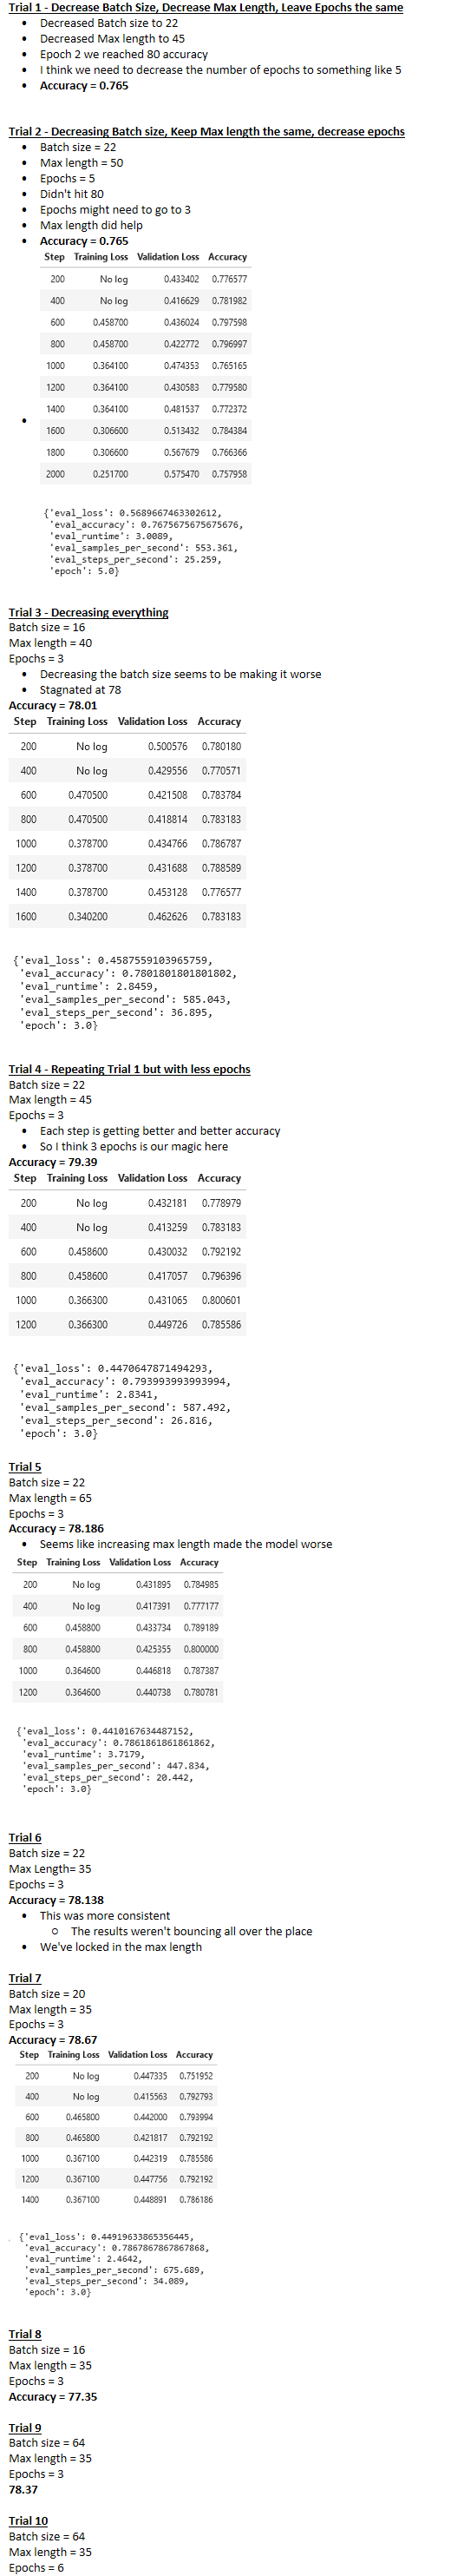

After messing with these parameters the best results I got was from Trial 4 by setting MAX_LENGTH to 45, Batch size to 22, and number of epochs to 3. So I trained the model using these values.

In [18]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
#epochs = 10
training_args = TrainingArguments(num_train_epochs=3,
                                  do_train=True,
                                  report_to=None,
                                  output_dir="/kaggle/working",
                                  evaluation_strategy="steps",
                                  eval_steps=200,
                                  learning_rate=1e-5,
                                  #batch sizes
                                  #per_device_train_batch_size=32,
                                  #per_device_eval_batch_size=32)
                                  per_device_train_batch_size=22,
                                  per_device_eval_batch_size=22)

trainer = Trainer(model = model, 
                  args = training_args,
                  train_dataset = ds_train, 
                  eval_dataset = ds_eval,
                  compute_metrics = compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("Using GPU")
else:
    device = "cpu"

Using GPU


In [20]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

# Training Model

In [21]:
torch.set_grad_enabled(True)
trainer.train()
trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy
200,No log,0.432181,0.778979
400,No log,0.413259,0.783183
600,0.458600,0.430032,0.792192
800,0.458600,0.417057,0.796396
1000,0.366300,0.431065,0.800601
1200,0.366300,0.449726,0.785586


{'eval_loss': 0.4470647871494293,
 'eval_accuracy': 0.793993993993994,
 'eval_runtime': 2.7931,
 'eval_samples_per_second': 596.112,
 'eval_steps_per_second': 27.21,
 'epoch': 3.0}

So the accuracy for this NLP using this dataset ended up being : #

# Testing Model

TRIGGER WARNING

Some of the text in the data set may contain vulgar words and phrases

In [22]:
df_test = pd.read_csv("https://raw.githubusercontent.com/Matthew-Bustamante/CS39AA-Project-Cyberbullying/main/CyberBullying_Comments_Dataset.csv")
df_test.head()

,Text,CB_Label
0,damn there is someones nana up here at beach w...,0
1,no kidding! dick clark was a corpse mechanical...,0
2,i read an article on jobros and thought damn w...,0
3,I got one fucking day of sprinkles and now it'...,0
4,I was already listening to Elliott smith and ...,0


In [23]:
ds_test_raw = Dataset.from_pandas(df_test)
ds_test_raw[0]

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


{'Text': 'damn there is someones nana up here at beach with one. dont think ic an steal and get to you quickly tho ;(',
 'CB_Label': 0}

In [24]:
ds_test = ds_test_raw.map(tokenize_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

In [25]:
preds = trainer.predict(test_dataset=ds_test)

In [26]:
test_preds = np.apply_along_axis(np.argmax, 1, preds.predictions)

In [27]:
df_test['preds'] = test_preds.tolist()
df_test['CB_Label'] = df_test['preds'].apply(lambda x: class_idx2tok[x])
df_test.head()

,Text,CB_Label,preds
0,damn there is someones nana up here at beach w...,0,0
1,no kidding! dick clark was a corpse mechanical...,1,1
2,i read an article on jobros and thought damn w...,0,0
3,I got one fucking day of sprinkles and now it'...,1,1
4,I was already listening to Elliott smith and ...,1,1


In conclusion, I was expecting the NLP to out perform the baseline model signifcantly and while it did give better accuracy I was expecting the accuracy to be at least in the 80 percentage range.  However when comparing my results to others who have used an existing NLP with this dataset my results match what other people have done.  I think if were to continue working on this project I would probably build my own NLP, as I would be able to ajust so much more and be able to fine tune it with this dataset.  I also think that by analyzing the data better and performing more tests on it would also help as well.  Overall this project was really fun,  seeing a model being able to recognize cyberbullying was really cool and it gave me hope for the future of AI, that we can build and train models that are beneficial to society. 